# Forecasting the 24 Hour PM2.5 Particle Concentration in Milan

### Employing various Auto regression and Deep learning models for forecasting AQI

### 1. Importing Data

The data that I am using here is publicly available in Kaggle and you can access it using the link here - https://www.kaggle.com/wiseair/air-quality-in-milan-summer-2020/tasks?taskId=2285 

* The data are the time series of the concentration of Particulate Matter 2.5 in the air of Milan.
* The data have been sampled using a laser-scattering PM2.5 sensor.
* The sampling frequency varies from 1/15min to 1/1h. The dataset contains hourly means.
* Data have been sampled in Milan, at 45.4582861 North 9.1675597 East.
* Data have been sampled from 2020-07-24 to 2020-09-20.

##### The main objective is to forecast the value of the time series within 24 hours.

To meet this objective, we will during the project,

1. Clean the data, check for any missing data point.
2. Perform EDA to determine whether our dataset is stationary or not.
3. Select Model Parameters using the graphical methods.
4. Perform Deep Learning using suitable methodology.
5. Derive Conclusions and select the best model.
6. Summary and Future Actions

In [66]:
# Let us first import all necessary modules for computing forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
from scipy import stats
import scipy

In [67]:
# loading the dataset
df_milan = pd.read_csv('aq_milan_summer_2020.csv')
df_milan.head()

,local_datetime,pm2p5
0,2020-07-24 18:00:00,11.67
1,2020-07-24 19:00:00,9.25
2,2020-07-24 20:00:00,6.29
3,2020-07-24 21:00:00,5.50
4,2020-07-24 22:00:00,9.50


In [68]:
print(f'The total no of observations in the dataset are {df_milan.shape[0]}')

The total no of observations in the dataset are 1398


In [69]:
# Lets check the datatypes in the dataset
df_milan.dtypes

local_datetime     object
pm2p5             float64
dtype: object

In [70]:
#We can see that datetime variable is not of correct datatype. So lets tranform it.

df_milan.local_datetime = df_milan.local_datetime.astype('datetime64[ns]')
df_milan.describe()

,pm2p5
count,1398.000000
mean,12.668863
std,8.568262
min,1.000000
25%,6.000000
50%,10.225000
75%,17.937500
max,52.000000


In [71]:
# Setting datetime as the index

df_milan.set_index('local_datetime', inplace = True)
df_milan.head()

,pm2p5
local_datetime,
2020-07-24 18:00:00,11.67
2020-07-24 19:00:00,9.25
2020-07-24 20:00:00,6.29
2020-07-24 21:00:00,5.50
2020-07-24 22:00:00,9.50


In [72]:
# Lets check the frequency of the index
df_milan.index

DatetimeIndex(['2020-07-24 18:00:00', '2020-07-24 19:00:00',
               '2020-07-24 20:00:00', '2020-07-24 21:00:00',
               '2020-07-24 22:00:00', '2020-07-24 23:00:00',
               '2020-07-25 00:00:00', '2020-07-25 01:00:00',
               '2020-07-25 02:00:00', '2020-07-25 03:00:00',
               ...
               '2020-09-20 14:00:00', '2020-09-20 15:00:00',
               '2020-09-20 16:00:00', '2020-09-20 17:00:00',
               '2020-09-20 18:00:00', '2020-09-20 19:00:00',
               '2020-09-20 20:00:00', '2020-09-20 21:00:00',
               '2020-09-20 22:00:00', '2020-09-20 23:00:00'],
              dtype='datetime64[ns]', name='local_datetime', length=1398, freq=None)

In [73]:
#We can see that the frequency is strangenly not set automatically. So lets set it to hourly.

df_milan = df_milan.asfreq('h')
df_milan.index

DatetimeIndex(['2020-07-24 18:00:00', '2020-07-24 19:00:00',
               '2020-07-24 20:00:00', '2020-07-24 21:00:00',
               '2020-07-24 22:00:00', '2020-07-24 23:00:00',
               '2020-07-25 00:00:00', '2020-07-25 01:00:00',
               '2020-07-25 02:00:00', '2020-07-25 03:00:00',
               ...
               '2020-09-20 14:00:00', '2020-09-20 15:00:00',
               '2020-09-20 16:00:00', '2020-09-20 17:00:00',
               '2020-09-20 18:00:00', '2020-09-20 19:00:00',
               '2020-09-20 20:00:00', '2020-09-20 21:00:00',
               '2020-09-20 22:00:00', '2020-09-20 23:00:00'],
              dtype='datetime64[ns]', name='local_datetime', length=1398, freq='H')

#### Section Summary

1. Imported the data and transformed the date into datetime variable.
2. Changed the dataframe index to datetime index and set frequency to hour.

### 2. Exploratory Data Analysis

#### Objectives of this section

1. Check the run sequence plot of the data and check the data for stationarity.
2. Plot histograms, ACF and PACF plots to determine the further actions required to acheive stationarity.
3. Determine the hyper-parameters such as p, d, q and P, D, Q, s.

In [78]:
# Setting default plotsize
plotsize = (13,6)

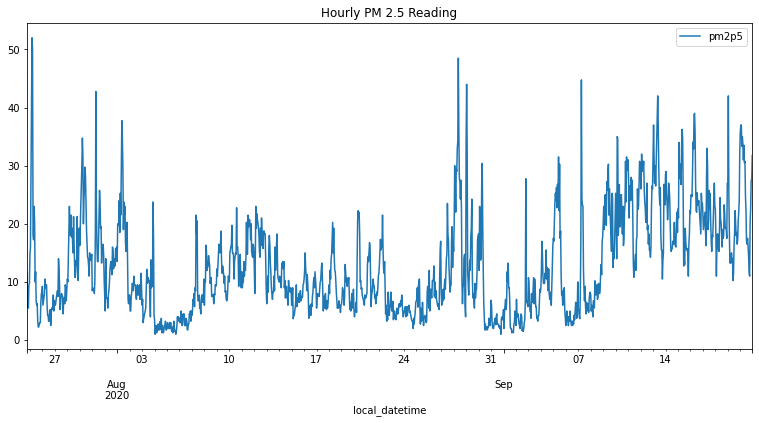

In [79]:
# lets plot the run sequence plot
df_milan.plot(figsize=plotsize, title='Hourly PM 2.5 Reading');

It seems that our data certainly doesn't contain any type of trend but looks like we don't have constant mean and variance through out our data.

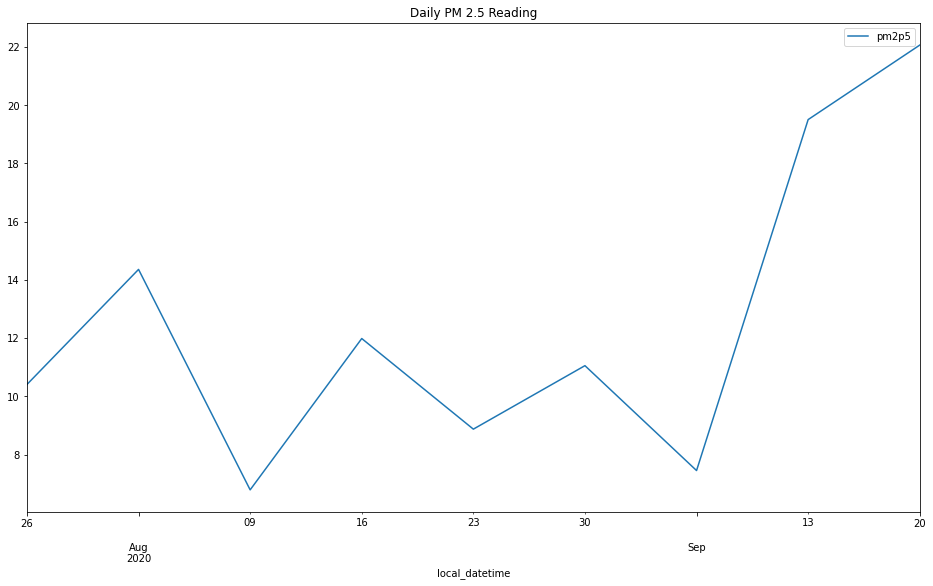

In [13]:
# Lets try to check if we have any kind of seasonality in the data.

df_milan_weekly = df_milan.resample('W').mean()
df_milan_weekly.plot(figsize=plotsize, title='Daily PM 2.5 Reading');

We have only two month's worth of data, so only type of seasonality we have checked is weekly. But here also, it very difficult to identify any kind of proper seasonality

In [15]:
# To reaffirms our doubts about mean and varaince lets divide our data into manageable chucks and caculate means and variances

chunks = np.split(df_milan.pm2p5, indices_or_sections = 6)

print(f'The mean of the chunks are')
print(np.mean(chunks, axis = 1))
print(f'The variance of the chunks are')
print(np.var(chunks, axis = 1))

The mean of the chunks are
[13.06523605  9.56566524  9.44454936  9.34579399 12.09321888 22.49871245]
The variance of the chunks are
[67.92327387 37.06547606 14.97381278 64.96476257 80.05908706 47.00595972]


Clearly we don't have constant mean and variance

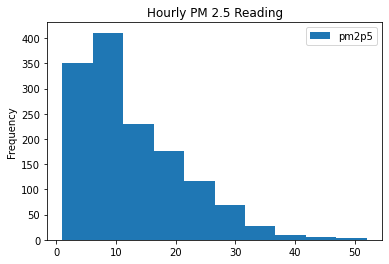

In [16]:
# Lets plot the histogram for our latter reference

df_milan.plot.hist();
plt.title('Hourly PM 2.5 Reading');

In [17]:
#So, mean varies quite a bit over the entire period so does our variance.
#Lets check for auto correlation here

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot

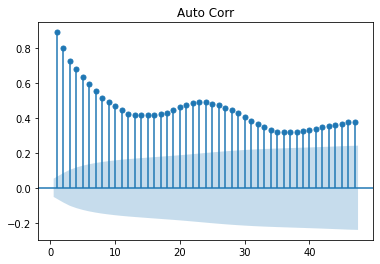

In [18]:
acf_plot = plot_acf(df_milan.pm2p5, lags = range(1,48), title = 'Auto Corr', zero = False)

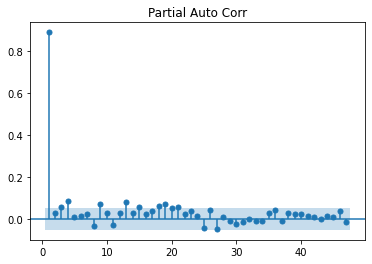

In [19]:
pacf_plot = plot_pacf(df_milan.pm2p5, lags = range(1,48), title = 'Partial Auto Corr', zero = False)

We see there is some kind of Auto-correlation in the data and probably its mostly because of the lag-1 Partial Autocorrelation.

After doing visual inspection now its time to check out data statistically. We will conduct the Augmented Dickey–Fuller test.

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

In [20]:
# lets define our hypothesis testing function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            -2.748892
p-value                    0.065953
Lags Used                 20.000000
Observations Used       1377.000000
Critical Value (1%)       -3.435108
Critical Value (5%)       -2.863641
Critical Value (10%)      -2.567889
dtype: float64


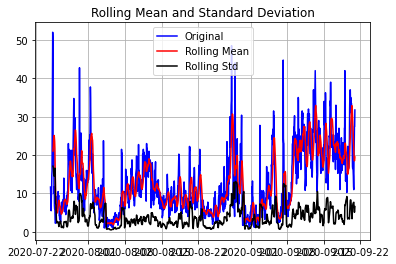

In [17]:
dftest(df_milan.pm2p5)

Clearly, the time series is non-stationary as the p-value is 0.065 higher that alpha (confidence interval - 0.05). 

Now, to acheive stationarity we can adopt various strategies but the one which I am going to adopt is the simplest - Differencing. So lets perform 1st order differencing

In [21]:
df_milan['difference'] = df_milan.diff()

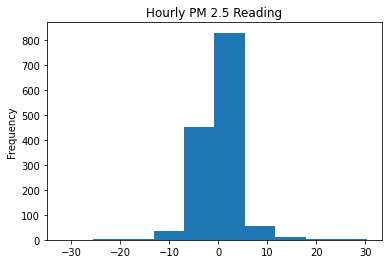

In [22]:
# Lets check out dataset for normality

df_milan['difference'].plot.hist();
plt.title('Hourly PM 2.5 Reading');

Test Statistic         -1.346356e+01
p-value                 3.491807e-25
Lags Used               2.100000e+01
Observations Used       1.375000e+03
Critical Value (1%)    -3.435115e+00
Critical Value (5%)    -2.863644e+00
Critical Value (10%)   -2.567890e+00
dtype: float64


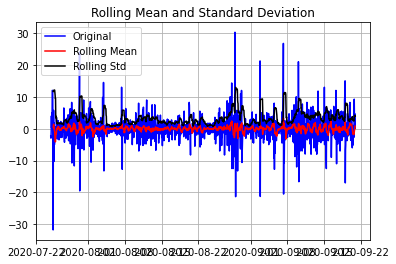

In [23]:
# testing for rejecting null hypothesis
dftest(df_milan.difference.dropna())

So, clearly we have acheived stationarity as well as quite contant mean and variance. Now its time to check the auto correlation and partial auto correlation

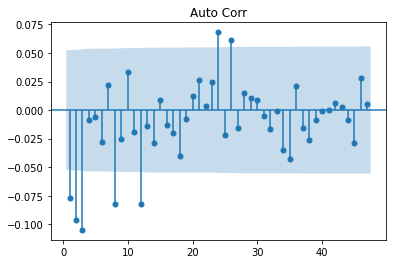

In [24]:
acf_plot = plot_acf(df_milan.difference.dropna(), lags = range(1,48), title = 'Auto Corr', zero = False)

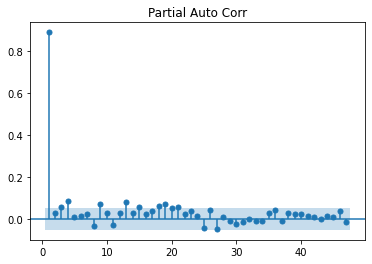

In [25]:
pacf_plot = plot_pacf(df_milan.pm2p5, lags = range(1,48), title = 'Partial Auto Corr', zero = False)

By looking at PACF plot it looks like we have on our hand an AR-1 Model (p = 1). Also, ACF plot has all negative lags now, which means our differencing operation has treated our dataset for auto-correlation. 

Also, it suggests we chose MA-3 model with q = 3 and d = 1.

#### Outcomes of this section

1. We identified that our data is not stationary - i.e. it didn't had constant mean and variance. Also it contained auto-correlation
2. There is no seasonality as such, but we will keep our options open during the model selection.
3. We performed hypothesis testing to confirm our assumptions.
4. We performed first order differencing operating and acheieved sigificant stationarity which was also confirmed by the ADF hypothesis test results.
5. We identified our hyper parameters as below
    * p = 1
    * d = 1
    * q = 3

### 3. Model Selection and Evaluation


#### Objectives of this section

1. We will try three models here
       a. ARIMA Model
       b. SARIMAX Model
       c. Simple RNN Model
2. Select the best model using Mean absolute percentage error metrics

In [26]:
# Defining the cross validation function for the arima model

def cross_validate_arima(series,horizon,start,step_size,order,seasonal_order,trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = ARIMA(series[:i+1], #only using data through to and including start 
                      order=order, 
                      seasonal_order=seasonal_order, 
                      trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [28]:
# Setting the input parameters for the ARIMA Model

series = df_milan.pm2p5
horizon = 24
step_size = 1
order = (1,1,3)
seasonal_order = (0,0,0,0)

cv1 = cross_validate_arima(df_milan.pm2p5,
                           horizon = horizon,
                           start = 1350,
                           step_size = step_size,
                           order = order,
                           seasonal_order = seasonal_order)

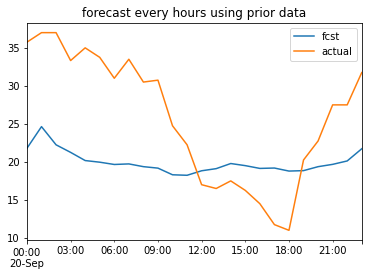

In [29]:
# plotting actual values against forecasted values

cv1.plot(title = 'forecast every hours using prior data');

In [37]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return np.mean(np.abs((df_cv.actual - df_cv.fcst) / df_cv.actual)) * 100
    #return (abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum())

In [38]:
print(f'Mean Absolute Percentage Error for ARIMA Model is {mape(cv1)}')

Mean Absolute Percentage Error for ARIMA Model is 31.75584533535828


In [40]:
# Defining cross validation function for SARIMAX 
def cross_validate_sarimax(series,horizon,start,step_size,order,seasonal_order,trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = SARIMAX(series[:i+1], #only using data through to and including start 
                      order=order, 
                      seasonal_order=seasonal_order, 
                      trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [42]:
# Lets try to model using a weekly component into account
import warnings 
warnings.filterwarnings("ignore")

series = df_milan.pm2p5
horizon = 24
step_size = 1
order = (1,1,3)
seasonal_order = (1,1,3,7)

cv2 = cross_validate_sarimax(df_milan.pm2p5,
                             horizon = horizon,
                             start = 1350,
                             step_size = step_size,
                             order = order,
                             seasonal_order = seasonal_order)

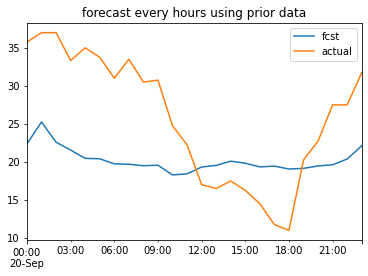

In [43]:
cv2.plot(title = 'forecast every hours using prior data');

In [44]:
print(f'Mean Absolute Percentage Error for SARIMAX Model is {mape(cv2)}')

Mean Absolute Percentage Error for SARIMAX Model is 31.82143867345855


The MAPE for SARIMAX is higher that ARIMA so it can be safely assumed that our data definitely doesn't contains any significant seasonal component.

So, finally lets also try to fit a simple RNN Model to performing our forecasting task

In [45]:
# Importing necessary modules

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [46]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(forecast_series, input_hours, test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    #forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours].values # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:].values # test data is the remaining test_hours
    
    print(f'The length of training data is {len(list(train))}')
    print(f'The length of test data set is {len(list(test))}')

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [47]:
forecast_series = df_milan.pm2p5
input_hours = 12
test_hours = 36

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(forecast_series, input_hours, test_hours))

The length of training data is 1362
The length of test data set is 36


In [49]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (450, 12, 1)
Training output shape: (450,)
Test input shape: (12,)
Test output shape: (24,)


In [54]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    
    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='MeanAbsolutePercentageError', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [55]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

In [56]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

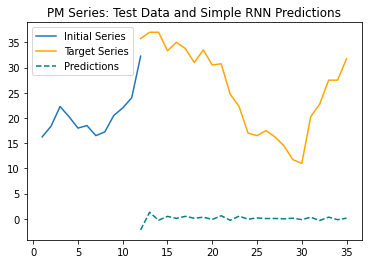

In [57]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

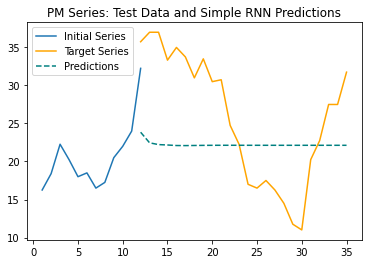

In [58]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [59]:
y_preds_rnn = predict(test_X_init, n_steps=len(test_y), model=model)

In [62]:
def mape(y_pred, y_actual):
    return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

In [80]:
print(f'Mean Absolute Percentage Error for RNN Model is {mape(y_preds_rnn, test_y)}')

Mean Absolute Percentage Error for RNN Model is 33.49870105163998


Here, we can see that we have not been able better the performance acheived by the normal ARIMA Model. Also the Plot suggests that our model simply predicts a straight line into the future.

#### Outcomes of this section

1. We trained and tested three models - ARIMA, SARIMAX and a Simple RNN Model. The performance of each model was measured using Mean Absolute Percentage Error Metric.
2. For each model we kept hold out set to predict 24 hours into the future.
3. The ARIMA Model performed best, with MAPE value of 31.755

### 4. Conclusions and Future Directions

We started this project with an objective of determining the best model to forecast 24 hours into future the PM2.5 concentration value in Milan.

In conclusion we can state that, The ARIMA Model forecast with minimum MAPE and proves to be best among SARIMAX and RNN Models.

To further improve our performance we can,

1. Also consider the LSTM Models which have proven better track record for Time-series data. However, due to paucity of time we were not able to perform LSTM modelling as part of our project.
2. The dataset was actually proved to be too small for any such forecasting excercise; larger dataset running into probably a complete quarter, or year would be more helpful.
3. We could also have used Auto ARIMA Models for automatically tune the best hyper-parameter using AIC metric. This could be tried in future for acheiving better performance.
4. We can also try other types of transformations on our data to acheive stationarity.

## Thank You, for visiting my page and going through this notebook.

# CIAO !!